# Use Case 8: Gender Classification in Face Images - Model Training

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision.transforms as transforms
from transformers import ViTForImageClassification, ViTImageProcessor, Trainer, TrainingArguments
from datasets import DatasetDict, concatenate_datasets, Dataset

import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

import os

/home/students/s289159/.conda/envs/airbnb-XAI-env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from io import BytesIO
from PIL import Image

import datasets



ds = datasets.load_dataset('nateraw/fairface')
#ds = datasets.load_dataset('nateraw/fairface', download_mode="force_redownload")


# Get number of rows in train and validation sets
num_train = ds["train"].num_rows
num_validation = ds["validation"].num_rows

# Add 'id' column
ds["train"] = ds["train"].add_column("id", list(range(num_train)))
ds["validation"] = ds["validation"].add_column("id", list(range(num_train, num_train + num_validation)))

# Select 2000 samples from train and 500 from validation
#small_train = ds["train"].shuffle(seed=42).select(range(2000))
#small_val = ds["validation"].shuffle(seed=42).select(range(500))

# Create a new DatasetDict
#ds = datasets.DatasetDict({"train": small_train, "validation": small_val})

Found cached dataset fairface (/home/students/s289159/.cache/huggingface/datasets/nateraw___fairface/default/0.0.0/9d7c8b446334b65d582e9a176cefe55c7a92dff164a02e433fe59b5dffdbfe36)
100%|██████████| 2/2 [00:00<00:00, 126.74it/s]


In [3]:
ds

DatasetDict({
    train: Dataset({
        features: ['img_bytes', 'age', 'gender', 'race', 'id'],
        num_rows: 86744
    })
    validation: Dataset({
        features: ['img_bytes', 'age', 'gender', 'race', 'id'],
        num_rows: 10954
    })
})

In [4]:
AGE_CLASSES = ["0-2", "3-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "more than 70"]
GENDER_CLASSES = ["Male", "Female"]
RACE_CLASSES = ["East Asian", "Indian", "Black", "White", "Middle Eastern", "Latino_Hispanic", "Southeast Asian"]

# Create dictionaries mapping class names to their index
age2id = {age: idx for idx, age in enumerate(AGE_CLASSES)}
gender2id = {gender: idx for idx, gender in enumerate(GENDER_CLASSES)}
race2id = {race: idx for idx, race in enumerate(RACE_CLASSES)}

# Create reverse mappings from index to class name
id2age = {idx: age for age, idx in age2id.items()}
id2gender = {idx: gender for gender, idx in gender2id.items()}
id2race = {idx: race for race, idx in race2id.items()}

In [5]:
def plot_age_distribution(train_df, val_df):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

    # Train dataset
    sns.countplot(x=train_df["age"], order=AGE_CLASSES, ax=axes[0], palette="Blues")
    axes[0].set_title("Age Distribution - Train")
    axes[0].set_xlabel("Age Group")
    axes[0].set_ylabel("Count")
    axes[0].tick_params(axis="x", rotation=90)  # Rotate labels

    # Validation dataset
    sns.countplot(x=val_df["age"], order=AGE_CLASSES, ax=axes[1], palette="Oranges")
    axes[1].set_title("Age Distribution - Validation")
    axes[1].set_xlabel("Age Group")
    axes[1].tick_params(axis="x", rotation=90)  # Rotate labels

    plt.tight_layout()
    plt.show()

# Function to plot gender distribution
def plot_gender_distribution(train_df, val_df):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    # Train dataset
    sns.countplot(x=train_df["gender"], order=GENDER_CLASSES, ax=axes[0], palette="Blues")
    axes[0].set_title("Gender Distribution - Train")
    axes[0].set_xlabel("Gender")
    axes[0].set_ylabel("Count")

    # Validation dataset
    sns.countplot(x=val_df["gender"], order=GENDER_CLASSES, ax=axes[1], palette="Oranges")
    axes[1].set_title("Gender Distribution - Validation")
    axes[1].set_xlabel("Gender")

    plt.tight_layout()
    plt.show()

# Function to plot race distribution
def plot_race_distribution(train_df, val_df):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    # Train dataset
    sns.countplot(x=train_df["race"], order=RACE_CLASSES, ax=axes[0], palette="Blues")
    axes[0].set_title("Race Distribution - Train")
    axes[0].set_xlabel("Race")
    axes[0].set_ylabel("Count")
    axes[0].tick_params(axis="x", rotation=90)  # Rotate labels

    # Validation dataset
    sns.countplot(x=val_df["race"], order=RACE_CLASSES, ax=axes[1], palette="Oranges")
    axes[1].set_title("Race Distribution - Validation")
    axes[1].set_xlabel("Race")
    axes[1].tick_params(axis="x", rotation=90)  # Rotate labels

    plt.tight_layout()
    plt.show()

# Function to plot age distribution
def plot_age_distribution_four_splits(train_df, test_df, new_unseen_df, drifted_df):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

    datasets = [train_df, test_df, new_unseen_df, drifted_df]
    titles = ["Train", "Test", "New Unseen", "Drifted"]
    palettes = ["Blues", "Greens", "Purples", "Reds"]

    for i, df in enumerate(datasets):
        sns.countplot(x=df["age"], order=AGE_CLASSES, ax=axes[i], palette=palettes[i])
        axes[i].set_title(f"Age Distribution - {titles[i]}")
        axes[i].set_xlabel("Age Group")
        axes[i].tick_params(axis="x", rotation=90)

    axes[0].set_ylabel("Count")  # Set y-label only on the first plot
    plt.tight_layout()
    plt.show()

# Function to plot gender distribution
def plot_gender_distribution_four_splits(train_df, test_df, new_unseen_df, drifted_df):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

    datasets = [train_df, test_df, new_unseen_df, drifted_df]
    titles = ["Train", "Test", "New Unseen", "Drifted"]
    palettes = ["Blues", "Greens", "Purples", "Reds"]

    for i, df in enumerate(datasets):
        sns.countplot(x=df["gender"], order=GENDER_CLASSES, ax=axes[i], palette=palettes[i])
        axes[i].set_title(f"Gender Distribution - {titles[i]}")
        axes[i].set_xlabel("Gender")

    axes[0].set_ylabel("Count")  
    plt.tight_layout()
    plt.show()

# Function to plot race distribution
def plot_race_distribution_four_splits(train_df, test_df, new_unseen_df, drifted_df):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

    datasets = [train_df, test_df, new_unseen_df, drifted_df]
    titles = ["Train", "Test", "New Unseen", "Drifted"]
    palettes = ["Blues", "Greens", "Purples", "Reds"]

    for i, df in enumerate(datasets):
        sns.countplot(x=df["race"], order=RACE_CLASSES, ax=axes[i], palette=palettes[i])
        axes[i].set_title(f"Race Distribution - {titles[i]}")
        axes[i].set_xlabel("Race")
        axes[i].tick_params(axis="x", rotation=90)

    axes[0].set_ylabel("Count")  
    plt.tight_layout()
    plt.show()



In [6]:
# Convert dataset to pandas dataframe
train_df = ds["train"].to_pandas()
val_df = ds["validation"].to_pandas()

train_df = ds["train"].to_pandas()
val_df = ds["validation"].to_pandas()

train_df["age"] = train_df["age"].map(lambda x: AGE_CLASSES[x])
val_df["age"] = val_df["age"].map(lambda x: AGE_CLASSES[x])

train_df["gender"] = train_df["gender"].map(lambda x: GENDER_CLASSES[x])
val_df["gender"] = val_df["gender"].map(lambda x: GENDER_CLASSES[x])

train_df["race"] = train_df["race"].map(lambda x: RACE_CLASSES[x])
val_df["race"] = val_df["race"].map(lambda x: RACE_CLASSES[x])

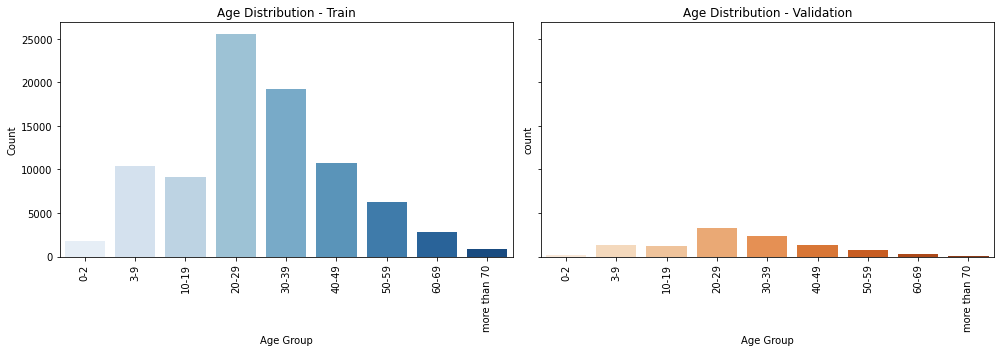

In [7]:
plot_age_distribution(train_df, val_df)

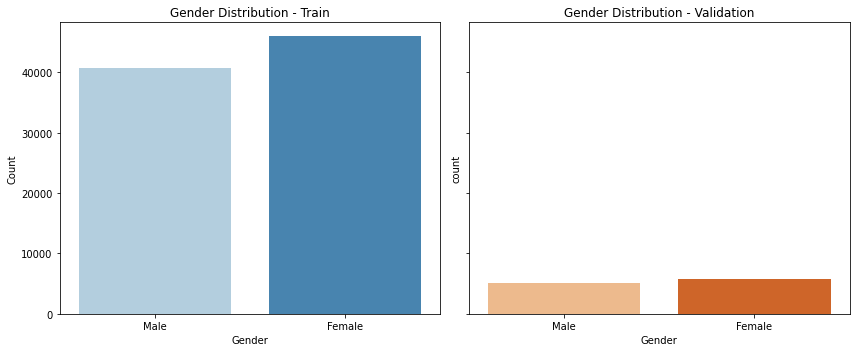

In [8]:
plot_gender_distribution(train_df, val_df)

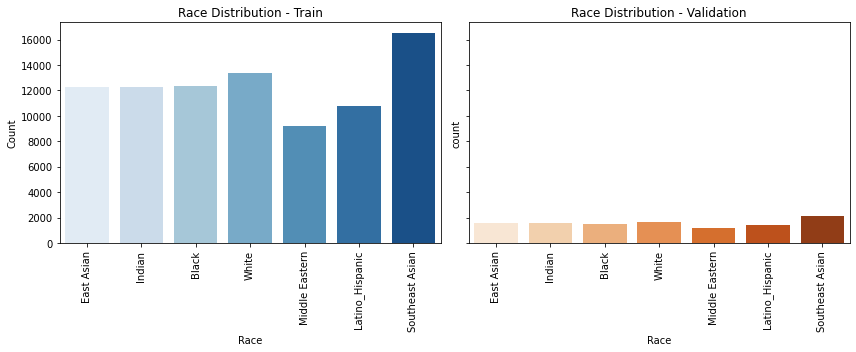

In [9]:
plot_race_distribution(train_df, val_df)

## Extract drifted data

In [10]:
drifted_race = "Black"

# Separate drifted samples (race == "Black")
drifted_train = ds["train"].filter(lambda example: example["race"] == race2id[drifted_race])
drifted_validation = ds["validation"].filter(lambda example: example["race"] == race2id[drifted_race])

# Merge drifted samples into a single dataset
drifted_dataset = concatenate_datasets([drifted_train, drifted_validation])

# Remove the drifted samples from the original sets
filtered_train = ds["train"].filter(lambda example: example["race"] != race2id[drifted_race])
filtered_validation = ds["validation"].filter(lambda example: example["race"] != race2id[drifted_race])

# Create a new DatasetDict
ds = DatasetDict({
    "train": filtered_train,
    "test": filtered_validation,
    "drifted": drifted_dataset
})

Loading cached processed dataset at /home/students/s289159/.cache/huggingface/datasets/nateraw___fairface/default/0.0.0/9d7c8b446334b65d582e9a176cefe55c7a92dff164a02e433fe59b5dffdbfe36/cache-6c365a412aefcade.arrow
Loading cached processed dataset at /home/students/s289159/.cache/huggingface/datasets/nateraw___fairface/default/0.0.0/9d7c8b446334b65d582e9a176cefe55c7a92dff164a02e433fe59b5dffdbfe36/cache-9b0db017ec63f5ed.arrow
Loading cached processed dataset at /home/students/s289159/.cache/huggingface/datasets/nateraw___fairface/default/0.0.0/9d7c8b446334b65d582e9a176cefe55c7a92dff164a02e433fe59b5dffdbfe36/cache-d256e04dbf0212e0.arrow
Loading cached processed dataset at /home/students/s289159/.cache/huggingface/datasets/nateraw___fairface/default/0.0.0/9d7c8b446334b65d582e9a176cefe55c7a92dff164a02e433fe59b5dffdbfe36/cache-dff50d93e38749a7.arrow


In [11]:
ds

DatasetDict({
    train: Dataset({
        features: ['img_bytes', 'age', 'gender', 'race', 'id'],
        num_rows: 74425
    })
    test: Dataset({
        features: ['img_bytes', 'age', 'gender', 'race', 'id'],
        num_rows: 9438
    })
    drifted: Dataset({
        features: ['img_bytes', 'age', 'gender', 'race', 'id'],
        num_rows: 13835
    })
})

## Extract new unseen data

In [12]:
# Convert train dataset to Pandas DataFrame
train_df = ds["train"].to_pandas()

# Convert all relevant columns to string before concatenation
train_df["stratify_col"] = train_df["gender"].astype(str) + "_" + train_df["race"].astype(str) + "_" + train_df["age"].astype(str)

# Define stratified sampling strategy
splitter = StratifiedShuffleSplit(n_splits=1, test_size=30000, random_state=42)

# Perform split
for train_idx, unseen_idx in splitter.split(train_df, train_df["stratify_col"]):
    new_train_df = train_df.iloc[train_idx]
    new_unseen_df = train_df.iloc[unseen_idx]
    
# Reset index before converting back to Hugging Face Dataset
new_train_df = new_train_df.reset_index(drop=True)
new_unseen_df = new_unseen_df.reset_index(drop=True)

# Convert back to Hugging Face datasets
new_train_dataset = Dataset.from_pandas(new_train_df.drop(columns=["stratify_col"]))
new_unseen_dataset = Dataset.from_pandas(new_unseen_df.drop(columns=["stratify_col"]))

# Update DatasetDict
ds = DatasetDict({
    "train": new_train_dataset,
    "test": ds["test"],
    "drifted": ds["drifted"],
    "new_unseen": new_unseen_dataset
})

In [13]:
ds

DatasetDict({
    train: Dataset({
        features: ['img_bytes', 'age', 'gender', 'race', 'id'],
        num_rows: 44425
    })
    test: Dataset({
        features: ['img_bytes', 'age', 'gender', 'race', 'id'],
        num_rows: 9438
    })
    drifted: Dataset({
        features: ['img_bytes', 'age', 'gender', 'race', 'id'],
        num_rows: 13835
    })
    new_unseen: Dataset({
        features: ['img_bytes', 'age', 'gender', 'race', 'id'],
        num_rows: 30000
    })
})

In [14]:
# Convert the Hugging Face datasets to Pandas DataFrames
train_df = ds["train"].to_pandas()
test_df = ds["test"].to_pandas()
new_unseen_df = ds["new_unseen"].to_pandas()
drifted_df = ds["drifted"].to_pandas()

# Map the numeric values to the class names
train_df["age"] = train_df["age"].map(lambda x: AGE_CLASSES[x])
test_df["age"] = test_df["age"].map(lambda x: AGE_CLASSES[x])
new_unseen_df["age"] = new_unseen_df["age"].map(lambda x: AGE_CLASSES[x])
drifted_df["age"] = drifted_df["age"].map(lambda x: AGE_CLASSES[x])

train_df["gender"] = train_df["gender"].map(lambda x: GENDER_CLASSES[x])
test_df["gender"] = test_df["gender"].map(lambda x: GENDER_CLASSES[x])
new_unseen_df["gender"] = new_unseen_df["gender"].map(lambda x: GENDER_CLASSES[x])
drifted_df["gender"] = drifted_df["gender"].map(lambda x: GENDER_CLASSES[x])

train_df["race"] = train_df["race"].map(lambda x: RACE_CLASSES[x])
test_df["race"] = test_df["race"].map(lambda x: RACE_CLASSES[x])
new_unseen_df["race"] = new_unseen_df["race"].map(lambda x: RACE_CLASSES[x])
drifted_df["race"] = drifted_df["race"].map(lambda x: RACE_CLASSES[x])

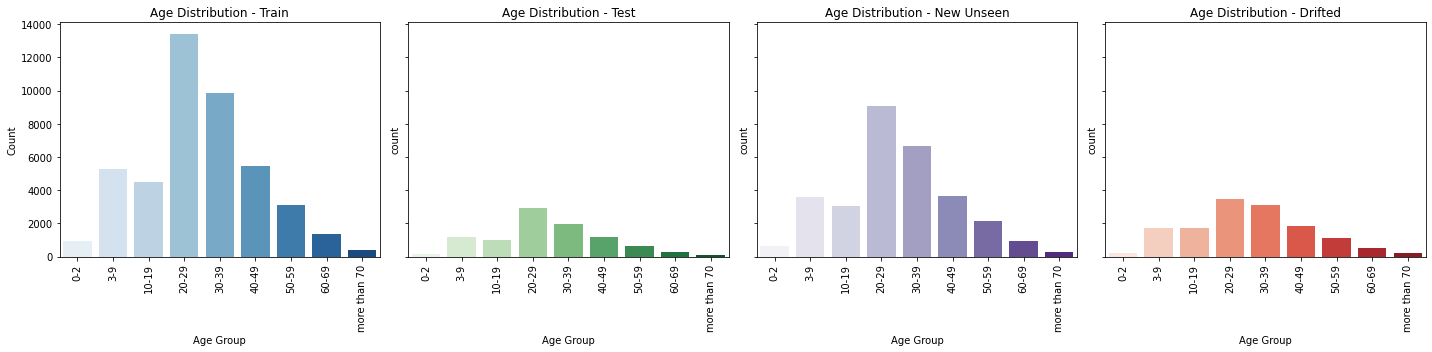

In [15]:
plot_age_distribution_four_splits(train_df, test_df, new_unseen_df, drifted_df)

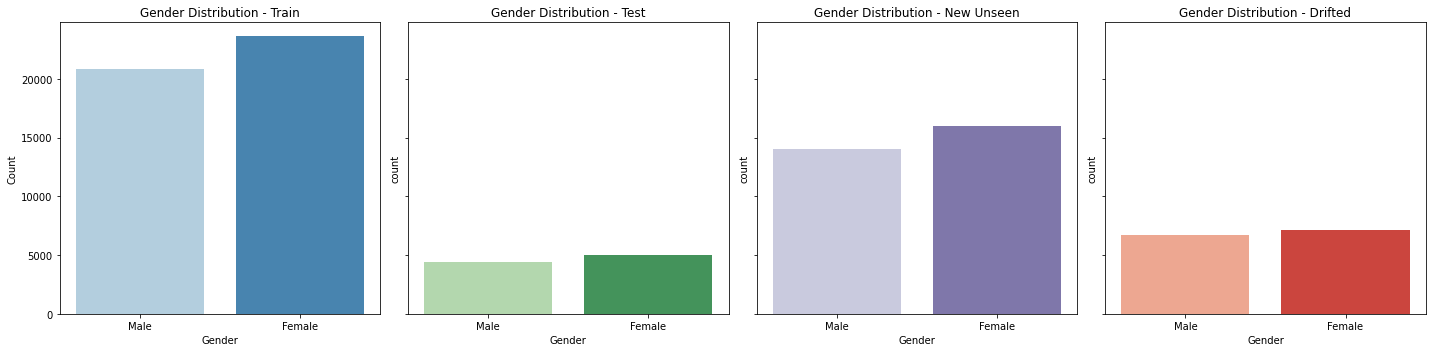

In [16]:
plot_gender_distribution_four_splits(train_df, test_df, new_unseen_df, drifted_df)

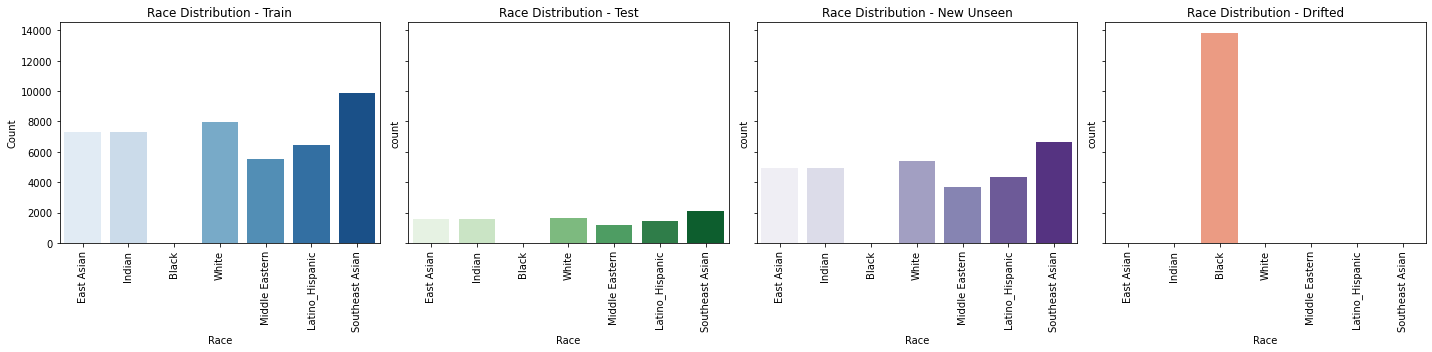

In [17]:
plot_race_distribution_four_splits(train_df, test_df, new_unseen_df, drifted_df)

## Save the Data Splits

In [18]:
ds.save_to_disk("fairface/data")

In [19]:
def bytes_to_pil(example_batch):
    example_batch['img'] = [
        Image.open(BytesIO(b)) for b in example_batch.pop('img_bytes')
    ]
    return example_batch

ds = ds.with_transform(bytes_to_pil)

## Define Image Transformations
Since the dataset is already transformed into PIL images, we need to preprocess them for ViT.

In [20]:


model_path = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_path)

def transform(example):
    # Process image
    encoding = processor(images=example["img"], return_tensors="pt")

    # Remove batch dimension (ViT expects (3, 224, 224), not (1, 3, 224, 224))
    encoding["pixel_values"] = encoding["pixel_values"].squeeze(0)

    # Convert labels to a tensor
    encoding["labels"] = torch.tensor(example["gender"], dtype=torch.long)  # Ensure correct dtype

    return encoding


## Apply Transformation to Dataset

In [21]:
ds["train"] = ds["train"].map(transform, remove_columns=["img_bytes", "age", "race", "id"])
ds["test"] = ds["test"].map(transform, remove_columns=["img_bytes", "age", "race", "id"])

train_dataset = ds["train"].with_format("torch")
test_dataset = ds["test"].with_format("torch")

Loading cached processed dataset at /home/students/s289159/.cache/huggingface/datasets/nateraw___fairface/default/0.0.0/9d7c8b446334b65d582e9a176cefe55c7a92dff164a02e433fe59b5dffdbfe36/cache-14eeda4db9e9c537.arrow


## Load Pretrained ViT Model

In [22]:
model = ViTForImageClassification.from_pretrained(
    model_path,
    num_labels=2,  # Gender classification (Male/Female)
    id2label={0: "Male", 1: "Female"},
    label2id={"Male": 0, "Female": 1},
    ignore_mismatched_sizes=True  # This will reset the classifier layer
)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Set Training Arguments

In [23]:
import sklearn

def compute_metrics(pred):
    labels = pred.label_ids
    print(pred)
    try:
        preds = pred.predictions.argmax(-1)
    except:
        preds = pred.predictions[0].argmax(-1)
    precision, recall, f1, _ = sklearn.metrics.precision_recall_fscore_support(
        labels, preds, average="macro", labels=list(set(labels))
    )
    print(sklearn.metrics.classification_report(labels, preds, digits=4))
    acc = sklearn.metrics.accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

In [24]:
training_args = TrainingArguments(
    output_dir="./fairface/saved_model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    learning_rate=5e-5,
    weight_decay=0.01,
    metric_for_best_model="f1",
    load_best_model_at_end=True,
    greater_is_better=True,
    logging_dir="./logs",
    logging_steps=50,
    push_to_hub=False,
    report_to="none"
)

/home/students/s289159/.conda/envs/airbnb-XAI-env/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## Initialize and Start Training

In [25]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=processor,
    compute_metrics=compute_metrics,
)

/tmp/ipykernel_3094574/2365787641.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [26]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.171200,0.157550,0.937063,0.936884,0.936404,0.937768
2,0.087400,0.170212,0.941619,0.941357,0.941301,0.941414
3,0.017600,0.236257,0.939818,0.939689,0.939250,0.941012
4,0.003700,0.277537,0.943420,0.943114,0.943503,0.942784
5,0.000200,0.287134,0.946493,0.946245,0.946251,0.946239


              precision    recall  f1-score   support

           0     0.9193    0.9482    0.9335      4399
           1     0.9535    0.9274    0.9402      5039

    accuracy                         0.9371      9438
   macro avg     0.9364    0.9378    0.9369      9438
weighted avg     0.9376    0.9371    0.9371      9438

              precision    recall  f1-score   support

           0     0.9365    0.9384    0.9374      4399
           1     0.9461    0.9444    0.9453      5039

    accuracy                         0.9416      9438
   macro avg     0.9413    0.9414    0.9414      9438
weighted avg     0.9416    0.9416    0.9416      9438

              precision    recall  f1-score   support

           0     0.9161    0.9586    0.9369      4399
           1     0.9624    0.9234    0.9425      5039

    accuracy                         0.9398      9438
   macro avg     0.9392    0.9410    0.9397      9438
weighted avg     0.9408    0.9398    0.9399      9438

              preci

TrainOutput(global_step=3475, training_loss=0.06065970360267934, metrics={'train_runtime': 7088.9574, 'train_samples_per_second': 31.334, 'train_steps_per_second': 0.49, 'total_flos': 1.7212908193141248e+19, 'train_loss': 0.06065970360267934, 'epoch': 5.0})

## Evaluate the Model

In [27]:
metrics = trainer.evaluate()
print(metrics)


              precision    recall  f1-score   support

           0     0.9427    0.9425    0.9426      4399
           1     0.9498    0.9500    0.9499      5039

    accuracy                         0.9465      9438
   macro avg     0.9463    0.9462    0.9462      9438
weighted avg     0.9465    0.9465    0.9465      9438

{'eval_loss': 0.2871343493461609, 'eval_accuracy': 0.9464929010383556, 'eval_f1': 0.9462449445786155, 'eval_precision': 0.9462514075662097, 'eval_recall': 0.9462385031218871, 'eval_runtime': 161.7901, 'eval_samples_per_second': 58.335, 'eval_steps_per_second': 1.823, 'epoch': 5.0}


## Save the Model

In [28]:
trainer.save_model(os.path.join("fairface", "saved_model", "best_model"))